# SPRING MASS DAMPER FORCED VIBRATION PROBLEM USING PINN

PINN ➡ PHYSICS INFORMED NEURAL NETWORKS



> Deepxde library for PINN implementation



In [ ]:
%pip install deepxde

In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

dde.backend.set_default_backend("tensorflow")

print(f"DeepXDE version: {dde.__version__}")

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
DeepXDE version: 1.13.2


# ▶ Spring Mass Damper free vibration problem using PINN


---

The equation of motion for a single-degree-of-freedom spring-mass-damper system is given by:

$$
m\ddot{x}(t) + c\dot{x}(t) + kx(t) = 0
$$


In [ ]:
k = 400
m = 1
c = 4

# d, w0 = 2, 20
# mu, k = 2*d, w0**2

zeta = c/(2*np.sqrt(k*m))
w_n = np.sqrt(k/m)
w_d = w_n*np.sqrt(1 - zeta**2)

print("zeta: {:.2f}".format(zeta))
print("w_n: {:.2f}".format(w_n))
print("w_d: {:.2f}".format(w_d))

x0 = 0.1
v0 = 0
t_1 = 1

zeta: 0.10
w_n: 20.00
w_d: 19.90


In [ ]:
def ode_system(x, y):
  dy_t = dde.grad.jacobian(y, x)         # du/dt
  dy_tt = dde.grad.hessian(y, x)         # d²u/dt²
  return dy_tt + (c/m)*dy_t + (k/m)*y  # m*d²u/dt² + c*du/dt + ku = 0

In [ ]:
geom = dde.geometry.TimeDomain(0, t_1)

In [ ]:
# u(0) = 1
ic1 = dde.icbc.IC(geom, lambda x: x0, lambda _, on_initial: on_initial)

In [ ]:
def boundary_l(t, on_boundary):
  return on_boundary and dde.utils.isclose(t[0], 0)

def error_2(inputs, outputs, X):
  return dde.grad.jacobian(outputs, inputs, i=0, j=None) - v0

In [ ]:
# du/dt(0) = 0
ic2 = dde.icbc.OperatorBC(geom, error_2, boundary_l)

In [ ]:
data = dde.data.TimePDE(
    geom,
    ode_system,
    [ic1, ic2],
    num_domain=128,  # increase domain points if upper limit is increased
    num_boundary=2,
    # solution=lambda x: np.cos(x),
    # num_test=500,
)

# Neural network with input t and output u(t)
net = dde.maps.FNN([1, 64, 64, 64, 1], "sin", "Glorot uniform")

model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=0.001, loss_weights=[0.00005, 1, 1])
losshistory, train_state = model.train(iterations=20000)


Compiling model...
Building feed-forward neural network...
'build' took 0.059650 s

'compile' took 2.653585 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.06e-01, 1.00e+00, 4.13e-02]    [1.06e-01, 1.00e+00, 4.13e-02]    []  
1000      [4.00e-02, 3.68e-03, 4.15e-03]    [4.00e-02, 3.68e-03, 4.15e-03]    []  
2000      [1.65e-02, 8.60e-04, 1.20e-04]    [1.65e-02, 8.60e-04, 1.20e-04]    []  
3000      [9.73e-03, 2.61e-04, 1.72e-03]    [9.73e-03, 2.61e-04, 1.72e-03]    []  
4000      [7.75e-03, 3.44e-04, 1.45e-03]    [7.75e-03, 3.44e-04, 1.45e-03]    []  
5000      [5.62e-03, 1.82e-04, 2.33e-04]    [5.62e-03, 1.82e-04, 2.33e-04]    []  
6000      [4.48e-03, 8.63e-05, 2.26e-06]    [4.48e-03, 8.63e-05, 2.26e-06]    []  
7000      [3.66e-03, 5.90e-05, 1.83e-07]    [3.66e-03, 5.90e-05, 1.83e-07]    []  
8000      [3.13e-03, 4.39e-05, 4.12e-07]    [3.13e-03, 4.39e-05, 4.12e-07]    []  
9000      [2.79e-03, 3.78e-05, 1.

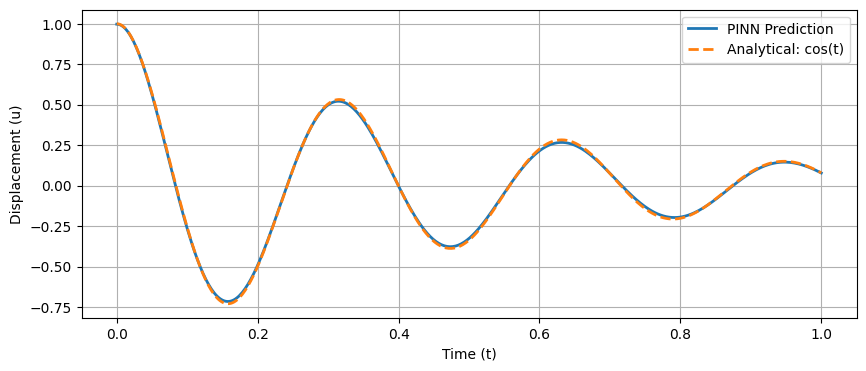

In [ ]:
# Generate time points
t = np.linspace(0, t_1, 500)[:, None]

# Solution for underdamped case
A = x0
B = (v0 + zeta * w_n * x0) / w_d

u_pred = model.predict(t)
u_true = np.exp(-zeta * w_n * t) * (A * np.cos(w_d * t) + B * np.sin(w_d * t))

# PINN prediction
u_pred = model.predict(t)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t, u_pred, label="PINN Prediction", linewidth=2)
plt.plot(t, u_true, "--", label="Analytical: cos(t)", linewidth=2)
plt.xlabel("Time (t)")
plt.ylabel("Displacement (u)")
plt.legend()
# plt.title("Mass-Spring Vibration using PINN (DeepXDE)")
plt.grid(True)
plt.show()

Error: 0.01590
Mean Error: 0.00715


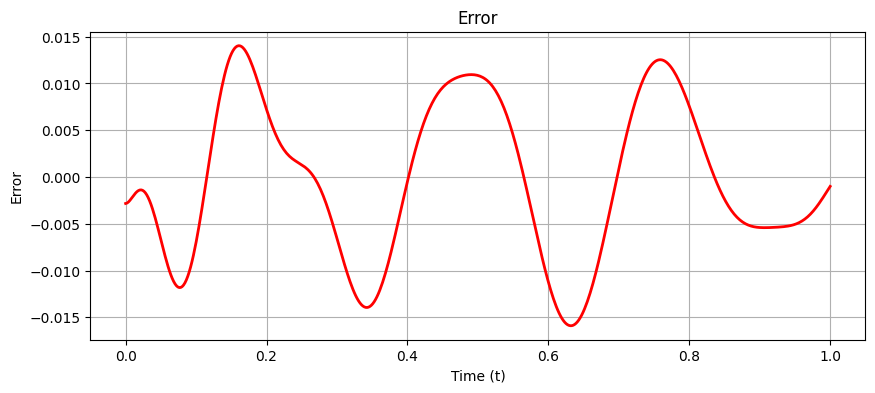

In [ ]:
error = u_pred - u_true
print("Error: {:.5f}".format(np.max(np.abs(error))))
print("Mean Error: {:.5f}".format(np.mean(np.abs(error))))

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t, error, linewidth=2, color='red')
plt.xlabel("Time (t)")
plt.ylabel("Error")
plt.title("Error")
plt.grid(True)
plt.show()

# ▶ ▶ Spring Mass Damper forced vibration problem using PINN


---

The equation of motion for a single-degree-of-freedom spring-mass-damper system is given by:

$$
m\ddot{x}(t) + c\dot{x}(t) + kx(t) = F_0cos(\omega t)
$$

---

  #  ✅ **Conclusions**

1. Normalize differential equation
2. Check weight values


---


📑 **Hyperparameters tuning**


* Iterations
* Weights
* num_domain
* layers & neurons



In [57]:
# PARAMETERS

k = 500  # large error for higher values
m = 10
c = 20
F0 = 0
w = 0
x0 = 1
v0 = 0
t_1 = 5

zeta = c/(2*np.sqrt(k*m))
w_n = np.sqrt(k/m)
w_d = w_n*np.sqrt(1 - zeta**2)

print("zeta: {:.4f}".format(zeta))
print("w_n: {:.4f}".format(w_n))
print("w_d: {:.4f}".format(w_d))

if zeta<1:
  print("Underdamped")
elif zeta==1:
  print("Critically damped")
else:
  print("Overdamped")

zeta: 0.1414
w_n: 7.0711
w_d: 7.0000
Underdamped


In [58]:
def ode_system(t, x):
  dx_t = dde.grad.jacobian(x, t)         # du/dt
  dx_tt = dde.grad.hessian(x, t)         # d²u/dt²
  return dx_tt + (c/m)*dx_t + (k/m)*x - (F0/m)*tf.cos(w*t)  # m*d²u/dt² + c*du/dt + ku = F0*cos(wt)

geom = dde.geometry.TimeDomain(0, t_1)

# u(0) = 1
ic1 = dde.icbc.IC(geom, lambda x: x0, lambda _, on_initial: on_initial)

In [59]:
def boundary_l(t, on_boundary):
  return on_boundary and dde.utils.isclose(t[0], 0)

def error_2(inputs, outputs, X):
  return dde.grad.jacobian(outputs, inputs, i=0, j=None) - v0

# du/dt(0) = 0
ic2 = dde.icbc.OperatorBC(geom, error_2, boundary_l)

In [60]:
data = dde.data.TimePDE(
    geom,
    ode_system,
    [ic1, ic2],
    num_domain=1024,  # increase domain points if upper limit is increased
    num_boundary=2,
    # solution=lambda x: np.cos(x),
    # num_test=500,
)

layer_size = [1] + [30] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

In [61]:
model.compile("adam", lr=0.001, loss_weights=[0.0005, 1, 1])

losshistory, train_state = model.train(iterations=300000)

Compiling model...
Building feed-forward neural network...
'build' took 0.201919 s

'compile' took 2.730938 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.54e-01, 1.00e+00, 2.83e-01]    [5.54e-01, 1.00e+00, 2.83e-01]    []  
1000      [7.37e-03, 7.77e-05, 1.89e-07]    [7.37e-03, 7.77e-05, 1.89e-07]    []  
2000      [4.60e-03, 2.97e-05, 1.48e-08]    [4.60e-03, 2.97e-05, 1.48e-08]    []  
3000      [3.42e-03, 1.46e-05, 1.51e-04]    [3.42e-03, 1.46e-05, 1.51e-04]    []  
4000      [2.90e-03, 1.02e-05, 4.76e-08]    [2.90e-03, 1.02e-05, 4.76e-08]    []  
5000      [2.59e-03, 8.04e-06, 1.05e-09]    [2.59e-03, 8.04e-06, 1.05e-09]    []  
6000      [2.38e-03, 6.36e-06, 1.86e-07]    [2.38e-03, 6.36e-06, 1.86e-07]    []  
7000      [2.19e-03, 5.31e-06, 4.40e-06]    [2.19e-03, 5.31e-06, 4.40e-06]    []  
8000      [1.97e-03, 4.76e-06, 2.35e-09]    [1.97e-03, 4.76e-06, 2.35e-09]    []  
9000      [1.63e-03, 1.89e-06, 6.

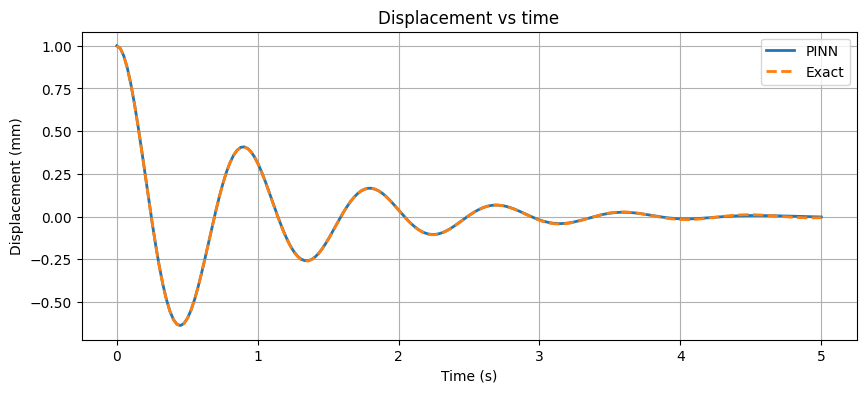

In [62]:
# Generate time points
t = np.linspace(0, t_1, 200)[:, None]

X = (F0/m)/(np.sqrt((w_n**2 - w**2)**2 + (2*zeta*w_n*w)**2))
phi = np.arctan((2*zeta*w_n*w)/(w_n**2 - w**2))
u_ss = X*np.cos(w*t - phi)

A = x0 - X*np.cos(phi)
B = (v0 + zeta*w_n*(x0 - X*np.cos(phi)) + w*X*np.sin(phi))/w_d
u_t = np.exp(-zeta*w_n*t)*(A*np.cos(w_d*t) + B*np.sin(w_d*t))

u_true = u_ss + u_t

# PINN prediction
u_pred = model.predict(t)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t, u_pred, label="PINN", linewidth=2)
plt.plot(t, u_true, "--", label="Exact", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Displacement (mm)")
plt.legend()
plt.title("Displacement vs time")
plt.grid(True)
plt.show()

Error: 0.00726
Mean Error: 0.00177


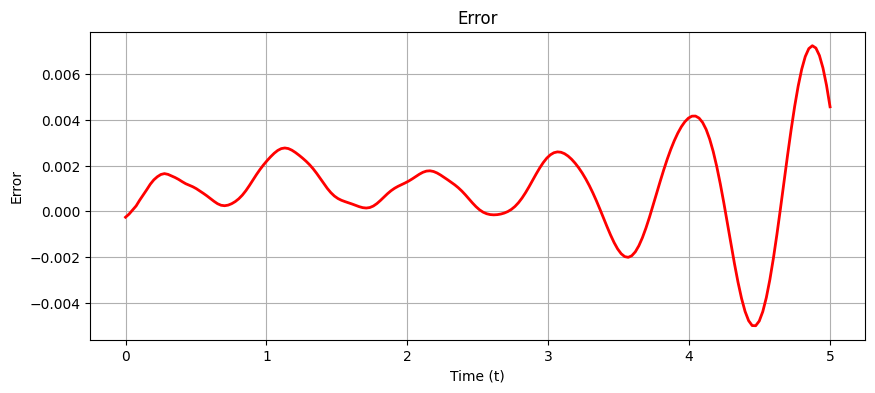

In [63]:
error = u_pred - u_true
print("Max Error: {:.5f}".format(np.max(np.abs(error))))
print("Mean Error: {:.5f}".format(np.mean(np.abs(error))))

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t, error, linewidth=2, color='red')
plt.xlabel("Time (t)")
plt.ylabel("Error")
plt.title("Error")
plt.grid(True)
plt.show()

In [65]:
A, phi*(180/np.pi), X

(np.float64(1.0), np.float64(0.0), np.float64(0.0))